In [13]:
#%pip install yfinance
#%pip install pmdarima
#!pip install tslearn

In [14]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from time import sleep

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

sleep(1)

forex_data_lowertf = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_5_minute, n_bars=1000)


prices = forex_data['close']
prices

datetime
2024-09-06 10:00:00    2519.07
2024-09-06 10:15:00    2519.39
2024-09-06 10:30:00    2518.44
2024-09-06 10:45:00    2516.53
2024-09-06 11:00:00    2518.15
                        ...   
2024-11-06 21:45:00    2667.10
2024-11-06 22:00:00    2664.85
2024-11-06 22:15:00    2662.74
2024-11-06 22:30:00    2660.05
2024-11-06 22:45:00    2660.85
Name: close, Length: 4000, dtype: float64

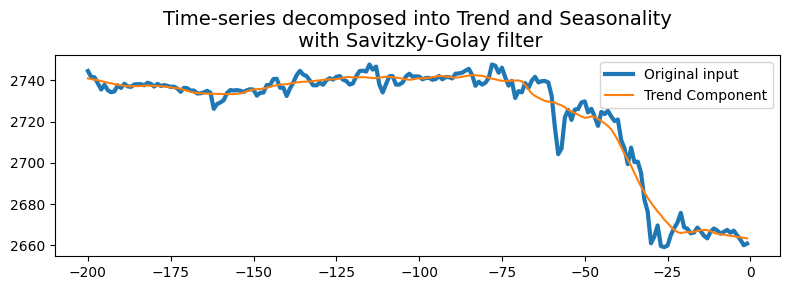

In [15]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
# Definition of Forecast Parameters
forecast_elements = 24

# Trend - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yvalues_trend, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

forecast = smodel.predict(n_periods=forecast_elements)

# Extend trend forecast
yvalues_trend_forecast = np.concatenate((yvalues_trend, forecast))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3022.703, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5763.358, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3008.390, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1915.625, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5782.619, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3025.657, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3023.855, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3023.797, Time=2.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3024.145, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3026.032, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-75.974, Time=1.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3024.301, Time=1.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1217.293, Time=1.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3022.322, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] 

In [17]:
def fft_forecast(signal, forecast_elements, target_harmonics=40):

    # Perform FFT on the seasonal component
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)

    # **2. Retain non-negative frequencies (including zero)**
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]

    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]

    # **3. Create extended indices including future points**
    reconstructed_length = N + forecast_elements
    extended_indices = np.arange(reconstructed_length)

    # **4. Reconstruct the signal using the selected harmonics**
    reconstructed_signal = np.zeros(reconstructed_length)

    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency

        if frequency == 0:  # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    return reconstructed_signal, num_harmonics

In [42]:
# Definition of Forecast Parameters
validation_elements = 8
seasonal_harmonics_list = np.arange(40, 80, 5)
seasonal_input_elements_list = np.arange(200, 800, 5)
visualization_elements = 30

# Initialize a list to store results
results = []

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Generate forecasts by looping over different parameters
for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        # Calculate starting index, and get input data slice
        start_idx = len(yvalues_seasonal) - validation_elements - seasonal_input_elements
        input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

        # Generate forecast with FFT
        yvalues_seasonal_forecast, num_harmonics = fft_forecast(
            input_slice,
            validation_elements+forecast_elements,
            seasonal_harmonics
        )
        
        # Convert forecasts to numpy arrays if they're pandas Series
        if isinstance(yvalues_seasonal_forecast, pd.Series):
            yvalues_seasonal_forecast = yvalues_seasonal_forecast.to_numpy()
        if isinstance(yvalues_seasonal, pd.Series):
            yvalues_seasonal = yvalues_seasonal.to_numpy()

        # Extract validation and test portions
        actual_validation = yvalues_seasonal[-validation_elements:]
        forecast_validation = yvalues_seasonal_forecast[-validation_elements-forecast_elements:-forecast_elements]

        # Calculate distances
        validation_distance = dtw.distance(actual_validation, forecast_validation)

        # Calculate cross-correlation for validation set
        validation_cross_corr = correlate(actual_validation, 
                                            forecast_validation, 
                                            mode='full')
        validation_max_corr = max(validation_cross_corr)

        # Store the results
        results.append({
            'seasonal_input_length': seasonal_input_elements,
            'seasonal_harmonics': seasonal_harmonics,
            'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
            'dtw_validation': validation_distance,
            'cc_validation': validation_max_corr,
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by='dtw_validation', ascending=True).head(20)

,seasonal_input_length,seasonal_harmonics,rmse_validation,dtw_validation,cc_validation
415,475,55,0.775697,1.719226,33.318156
580,700,60,1.073432,1.799373,30.951202
535,475,60,0.985024,1.806072,27.430719
775,475,70,0.796154,1.831832,38.367110
954,770,75,2.664249,1.859828,28.840707
655,475,65,0.991803,1.880728,26.845682
895,475,75,0.947394,1.911751,30.807820
777,485,70,0.753217,1.915613,35.134555
839,795,70,0.923836,1.939758,26.744686
676,580,65,1.045326,1.946045,30.896389


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
import math

def find_optimal_clusters(data, max_clusters=4):
    """Find optimal number of clusters using silhouette score."""
    # data is expected to be a 2D array of shape (n_samples, n_timepoints)
    n_samples = data.shape[0]
    data_reshaped = data.reshape(n_samples, -1)  # Ensure data is 2D
    
    # Try different numbers of clusters
    silhouette_scores = []
    for k in range(2, min(max_clusters + 1, n_samples)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_reshaped)
        score = silhouette_score(data_reshaped, cluster_labels)
        silhouette_scores.append(score)
    
    # Return optimal number of clusters
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_k

def plot_forecast_with_clusters_tfo(param_df, tfo_values, alpha_value=0.5, max_clusters=10):
    # Prepare common data slices and indices
    len_original_slice = visualization_elements + validation_elements
    len_forecast_slice = visualization_elements + validation_elements + forecast_elements
    original_slice_idx_list = np.arange(-len_original_slice, 0)
    forecast_slice_idx_list = np.arange(-len_original_slice, forecast_elements)
    
    # Prepare the prices slice and trend slice
    prices_slice = prices[-visualization_elements - validation_elements:]
    yvalues_trend_slice = yvalues_trend_forecast[-len_forecast_slice:]
    
    # Get the last data time
    last_datetime = forex_data_hour.index[-1]
    
    # Initialize lists to store forecasts
    seasonal_forecast_slices = []
    combined_forecast_slices = []
    
    # For each parameter set in param_df
    for idx, row in param_df.iterrows():
        seasonal_input_elements = int(row['seasonal_input_length'])
        seasonal_harmonics = int(row['seasonal_harmonics'])
        
        start_idx = len(yvalues_seasonal) - validation_elements - seasonal_input_elements
        input_slice = yvalues_seasonal[start_idx:start_idx + seasonal_input_elements]
        
        yvalues_seasonal_forecast, num_harmonics = fft_forecast(
            input_slice,
            validation_elements + forecast_elements,
            seasonal_harmonics
        )
        
        seasonal_forecast_slice = yvalues_seasonal_forecast[-len_forecast_slice:]
        combined_forecast_slice = yvalues_trend_slice + seasonal_forecast_slice
        
        seasonal_forecast_slices.append(seasonal_forecast_slice)
        combined_forecast_slices.append(combined_forecast_slice)
    
    # Convert to numpy arrays for easier manipulation
    seasonal_forecast_slices = np.array(seasonal_forecast_slices)
    combined_forecast_slices = np.array(combined_forecast_slices)

    # Get the validation and first half of forecast data for clustering
    end_idx = -forecast_elements//2
    start_idx = -(validation_elements + forecast_elements)
    clustering_data = seasonal_forecast_slices[:, start_idx:end_idx]
    n_samples = clustering_data.shape[0]
    data_reshaped = clustering_data.reshape(n_samples, -1)
    
    # Find optimal number of clusters
    n_clusters = find_optimal_clusters(clustering_data, 3)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_reshaped)
    
    # Group forecasts by cluster
    cluster_members = defaultdict(list)
    for idx, label in enumerate(cluster_labels):
        cluster_members[label].append(idx)
    
    # Calculate cluster means and intra-cluster distances
    cluster_means = {}
    intra_cluster_distances = {}
    for label, indices in cluster_members.items():
        cluster_data = combined_forecast_slices[indices]
        cluster_means[label] = np.mean(cluster_data, axis=0)
        
        # Compute intra-cluster distance (mean pairwise distance within the cluster)
        distances = []
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                dist = np.linalg.norm(cluster_data[i] - cluster_data[j])
                distances.append(dist)
        if distances:
            intra_cluster_distance = np.mean(distances)
        else:
            intra_cluster_distance = 0  # Single member in cluster
        intra_cluster_distances[label] = intra_cluster_distance
    

    # Plotting
    plt.figure(figsize=(12, 9))
    
    # Plot original price and trend
    plt.subplot(5, 1, (1,2))
    plt.plot(original_slice_idx_list / 4, prices_slice, label="Original Price")
    plt.plot(forecast_slice_idx_list / 4, yvalues_trend_slice, label='Trend Component', color='pink')
    
    # Plot combined forecasts with clusters
#    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    colors = ['forestgreen', 'red', 'darkorange', 'dodgerblue']
    for label, indices in cluster_members.items():
        # Plot individual forecasts with transparency
#        for idx in indices:
#            plt.plot(
#                forecast_slice_idx_list / 4,
#                combined_forecast_slices[idx],
#                color=colors[idx],
#                alpha=alpha_value
#            )
        # Plot cluster mean
        plt.plot(
            forecast_slice_idx_list / 4,
            cluster_means[label],
            color=colors[label],
            linewidth=2,
            label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
        )
    
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axvline(x=-validation_elements / 4, color='orange', linestyle='--')
    plt.axvline(x=validation_elements / 4, color='violet', linestyle='--')
    plt.title(f"Original Prices with Clustered Forecasts - {last_datetime}")
    plt.xlim(-math.ceil((visualization_elements+validation_elements)/4), math.ceil(forecast_elements/4))
    plt.xlabel("Hours")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend(loc = "lower left")
    
    # Plot original and reconstructed seasonal components
    plt.subplot(5, 1, (3,4))
    seasonal_original_slice = yvalues_seasonal[-visualization_elements - validation_elements:]
    plt.plot(original_slice_idx_list / 4, seasonal_original_slice, label="Original Seasonal", color='blue')
    
    # Plot seasonal forecasts with clusters
    seasonal_cluster_means = {}
    for label, indices in cluster_members.items():
        # Calculate seasonal cluster means
        seasonal_cluster_data = seasonal_forecast_slices[indices]
        seasonal_cluster_means[label] = np.mean(seasonal_cluster_data, axis=0)
        
        # Plot individual seasonal forecasts
        for idx in indices:
            plt.plot(
                forecast_slice_idx_list / 4,
                seasonal_forecast_slices[idx],
                color='pink',
                alpha=alpha_value
            )
        # Plot seasonal cluster mean
        plt.plot(
            forecast_slice_idx_list / 4,
            seasonal_cluster_means[label],
            color=colors[label],
            linewidth=2,
            label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
        )
    
    plt.axvline(x=-validation_elements / 4, color='orange', linestyle='--', label="Validation Start")
    plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
    plt.axvline(x=validation_elements / 4, color='violet', linestyle='--', label="70% Boundary")
    plt.title("Original Seasonal vs Clustered Seasonal Forecasts")
    plt.xlim(-math.ceil((visualization_elements+validation_elements)/4), math.ceil(forecast_elements/4))
    plt.xlabel("Hours")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend(loc = "lower left")
    

    # Ploting the TFO
    tfo_slope = tfo_values.diff()
    plt.subplot(5, 1, 5)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(x=-validation_elements / 4, color='orange', linestyle='--', label="Validation Start")
    plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
    for i in range(1, len(tfo_values)):
        tfoidx = [(i-len(tfo_values)-1)/12, (i-len(tfo_values))/12]
        if tfo_slope.iloc[i] >= 0.1:
            plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='green', linewidth=2)
        elif tfo_slope.iloc[i] <= -0.1:
            plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='red', linewidth=2)
        else:
            plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='lightgrey', linewidth=2)
    plt.xlim(-math.ceil((visualization_elements+validation_elements)/4), math.ceil(forecast_elements/4))
    plt.title('TrendFlex Oscillator (TFO)')

    plt.tight_layout()
    plt.show()
    
    return cluster_labels, cluster_members


In [70]:
# TFO Calculation Functions

def essf(series, period):
    """Ehlers' SuperSmoother Filter (ESSF)"""
    SQRT2xPI = np.sqrt(2.0) * np.pi
    alpha = SQRT2xPI / period
    beta = np.exp(-alpha)
    coef2 = -beta ** 2
    coef1 = 2.0 * beta * np.cos(alpha)
    coef0 = 1.0 - coef1 - coef2

    # Calculate sma2
    sma2 = (series + series.shift(1).fillna(series)) * 0.5

    # Initialize ESSF array
    ess = np.full(len(series), np.nan)
    ess[0] = sma2.iloc[0]

    for t in range(1, len(series)):
        sma2_t = sma2.iloc[t]
        ess_t1 = ess[t - 1]
        ess_t2 = ess[t - 2] if t - 2 >= 0 else 0.0

        ess[t] = coef0 * sma2_t + coef1 * ess_t1 + coef2 * ess_t2

    return pd.Series(ess, index=series.index)

def sum_diffs(series, period):
    """Sum of Differences"""
    E = np.zeros(len(series))
    for i in range(1, period + 1):
        shifted_series = series.shift(i).fillna(0)
        E += (series - shifted_series)
    E /= period
    return pd.Series(E, index=series.index)

def ema_recursive(series, period):
    """Exponential Moving Average (EMA) calculated recursively"""
    coef0 = 2.0 / (period + 1.0)
    coef1 = 1.0 - coef0
    EMA = np.full(len(series), np.nan)
    EMA[0] = series.iloc[0]

    for t in range(1, len(series)):
        series_t = series.iloc[t]
        EMA_t1 = EMA[t - 1]
        EMA[t] = coef0 * series_t + coef1 * EMA_t1

    return pd.Series(EMA, index=series.index)

def fRMS(series, period):
    """Fast Root Mean Square (fRMS)"""
    squared_series = series ** 2
    ema_squared = ema_recursive(squared_series, period)
    sqrt_ema = np.sqrt(ema_squared)
    result = np.nan_to_num(series / sqrt_ema, 0)
    return result

def trendflex(series, period_essf, period_tflx, period_frms):
    """Ehlers' TrendFlex Oscillator (TFO)"""
    essf_filtered = essf(series, period_essf)
    sum_diffs_filtered = sum_diffs(essf_filtered, period_tflx)
    tfo = fRMS(sum_diffs_filtered, period_frms)
    return tfo


# Parameters for Calculating TFO
periodTrendFlex = 20
useSuperSmootherOverride = False
periodSuperSmoother = 7.5
postSmooth = 33.0
if not useSuperSmootherOverride:
    periodSuperSmoother = periodTrendFlex * 0.5

# Calculate TFO
forex_data_lowertf['TFO'] = trendflex(forex_data_lowertf['close'], periodSuperSmoother, periodTrendFlex, postSmooth)

# Cut TFO data into suitable length (M15 to M5)
tfo_values = forex_data_lowertf['TFO'].iloc[-(visualization_elements+validation_elements)*3:]

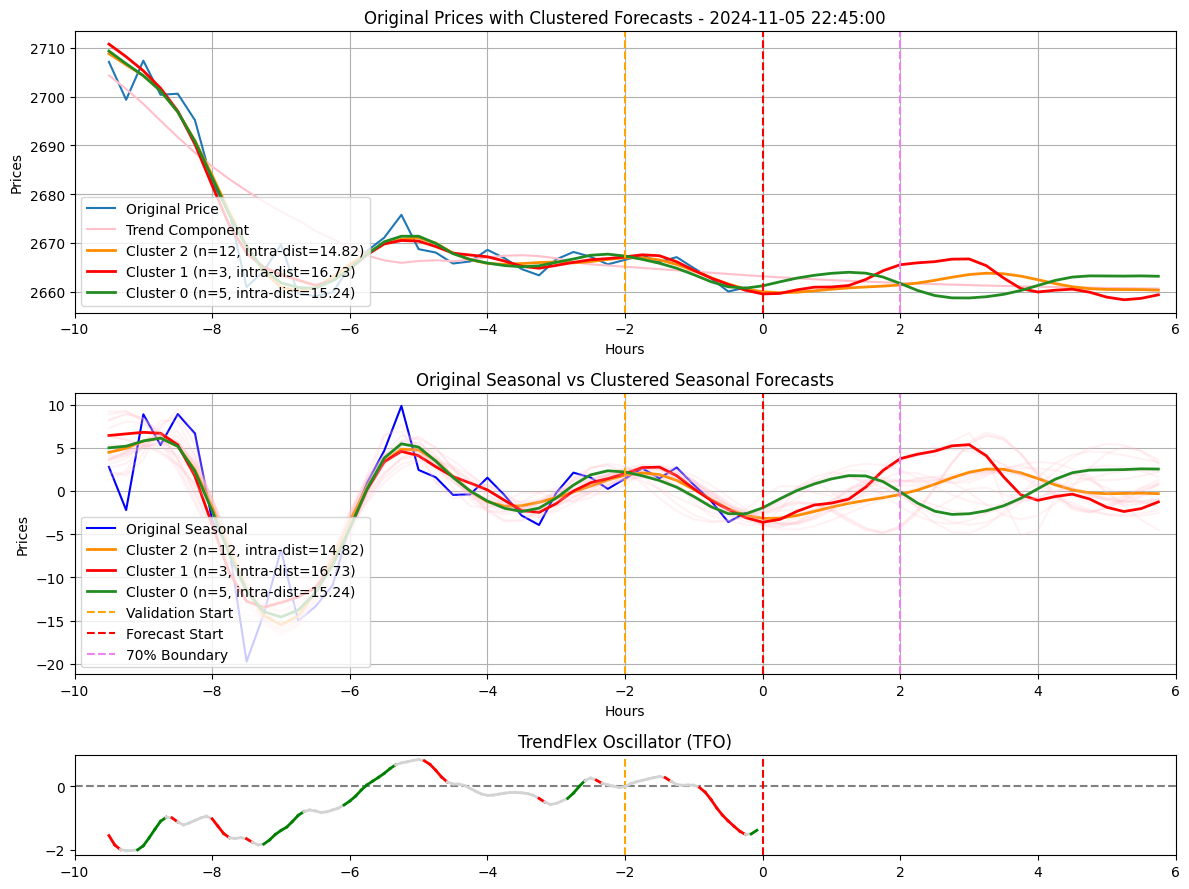

(array([2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 0],
       dtype=int32),
 defaultdict(list,
             {2: [0, 2, 3, 4, 5, 6, 8, 9, 12, 14, 16, 17],
              1: [1, 10, 13],
              0: [7, 11, 15, 18, 19]}))

In [83]:
# Sort the dataframe first
sorted_df = results_df.sort_values(by='dtw_validation', ascending=True).reset_index(drop=True)

plot_forecast_with_clusters_tfo(sorted_df[:20],tfo_values, 0.2)